In [ ]:
!pip install optuna

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, RidgeCV

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import joblib

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?id=1iEEHJT-52CJx71Kh3uUM8bje4JMFmbo2")

In [ ]:
df.sample(10)

,date,company_code,is_copied,language,last_published,changes_24h,changes_7d,added_24h,removed_24h,added_7d,removed_7d,contributors_7d,contributors_all_time,changes_1y,added_1y,removed_1y,stars,copy,watchers,market_cap_rank,price_share_usd,market_cap_usd
885,2/25/2018,CLT,True,Java,104d,0,0,0,0,0,0,0,0,0,0,0,4,2,14,5,204.793000,1.133911e+10
2508,4/30/2018,AAD,False,JavaScript,97d,0,0,0,0,0,0,0,2,0,0,0,0,1,14,6,0.347514,9.010020e+09
4630,8/16/2018,RXM,False,C,18d,0,0,0,0,0,0,0,10,215,1757456,425196,28,13,20,10,89.683844,1.463741e+09
1703,3/30/2018,AAD,False,JavaScript,66d,0,0,0,0,0,0,0,2,7,0,0,0,1,14,7,0.140412,3.640472e+09
4472,8/9/2018,KLS,False,JavaScript,391d,0,0,0,0,0,0,0,0,0,0,0,1,7,2,26,3.403779,3.705171e+08
2771,5/14/2018,SEO,True,C++,5d,0,0,0,0,0,0,0,7,55,0,0,31,31,25,5,14.056700,1.201493e+10
4932,8/30/2018,GBT,False,Unknown,24d,0,0,0,0,0,0,0,1,10,0,0,1,1,1,26,22.300851,3.837054e+08
3767,7/9/2018,RXM,False,C,5d,0,0,0,0,0,0,0,10,211,1755243,424903,27,12,19,13,139.965000,2.268488e+09
3227,6/16/2018,HDA,True,C,202d,0,0,0,0,0,0,0,1,0,0,0,1,2,2,13,256.853000,2.089714e+09
2584,5/6/2018,HBC,False,Unknown,2d,0,0,0,0,0,0,0,11,44,1397,125,117,68,56,4,1788.770000,3.061017e+10


In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

df['is_copied']= label_encoder.fit_transform(df['is_copied'])
df['company_code_enc']= label_encoder.fit_transform(df['company_code'])
df['language_enc']= label_encoder.fit_transform(df['language'])
df["number_of_stocks"] = df.market_cap_usd/df.price_share_usd


In [ ]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/len(df.index))*100}) 
missing_data

,total_missing,perc_missing
date,0,0.0
company_code,0,0.0
is_copied,0,0.0
language,0,0.0
last_published,0,0.0
changes_24h,0,0.0
changes_7d,0,0.0
added_24h,0,0.0
removed_24h,0,0.0
added_7d,0,0.0


In [ ]:
df['language'].value_counts()

Unknown       1225
C              818
Java           554
JavaScript     552
Python         513
CSS            326
C++            321
Go             301
HTML           263
Shell          250
Erlang         186
TypeScript      59
Ruby            45
PHP             36
Elixir          13
Vue              5
Name: language, dtype: int64

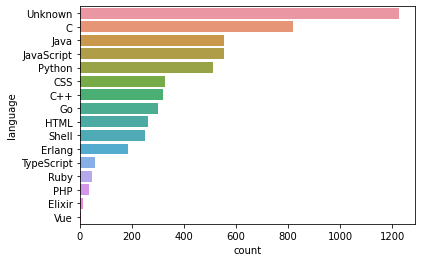

In [ ]:
sns.countplot(y ='language', data = df,order = df["language"].value_counts().index)
 
# Show the plot
plt.show()

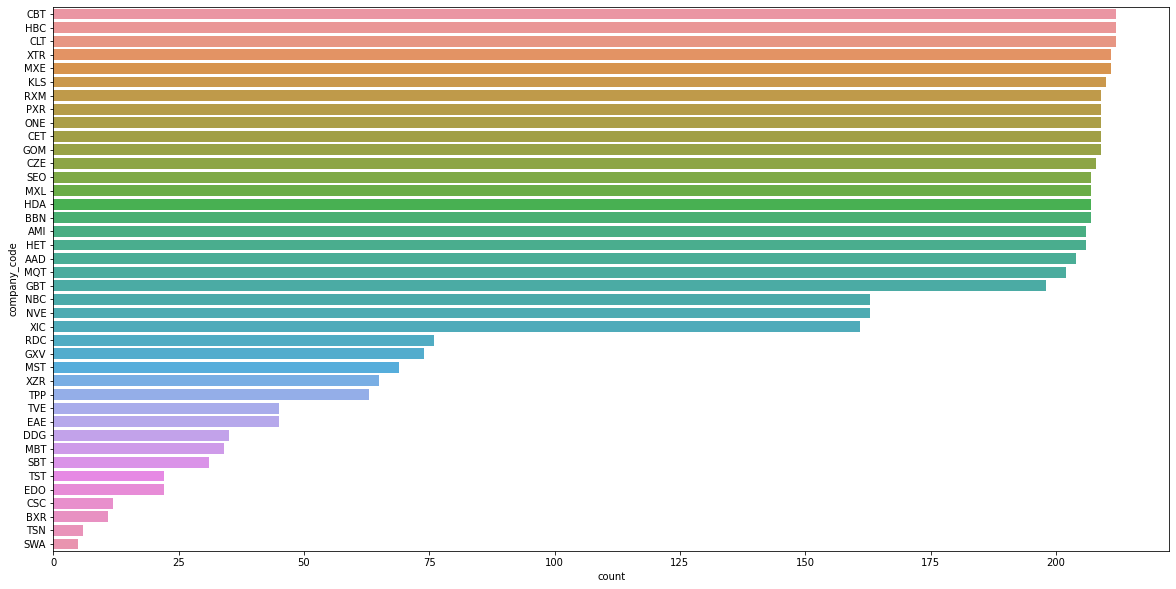

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
sns.countplot(y ='company_code', data = df,order = df["company_code"].value_counts().index)
 
# Show the plot
plt.show()

In [ ]:
#Koefisien Korelasinya
#df_a = df.drop(columns='price_share_usd')
r = pd.DataFrame((abs(df.corr()['price_share_usd']).sort_values(ascending = False)))
r

,price_share_usd
price_share_usd,1.000000
market_cap_usd,0.926513
watchers,0.824209
stars,0.777599
contributors_all_time,0.509665
market_cap_rank,0.361818
company_code_enc,0.261974
copy,0.195527
is_copied,0.146448
number_of_stocks,0.098975


In [ ]:
target = df["price_share_usd"]
independent = df[["market_cap_usd","watchers","stars","contributors_all_time","market_cap_rank","company_code_enc","copy"]]

In [ ]:
#p-value test

from sklearn.feature_selection import f_regression
anova, p = f_regression(independent, target)
frame = (pd.Series(p, index=independent.columns).sort_values(ascending= True))
#plt.title('p-value')
frame


market_cap_usd            0.000000e+00
watchers                  0.000000e+00
stars                     0.000000e+00
contributors_all_time     0.000000e+00
market_cap_rank          9.230337e-169
company_code_enc          1.737628e-86
copy                      3.027476e-48
dtype: float64

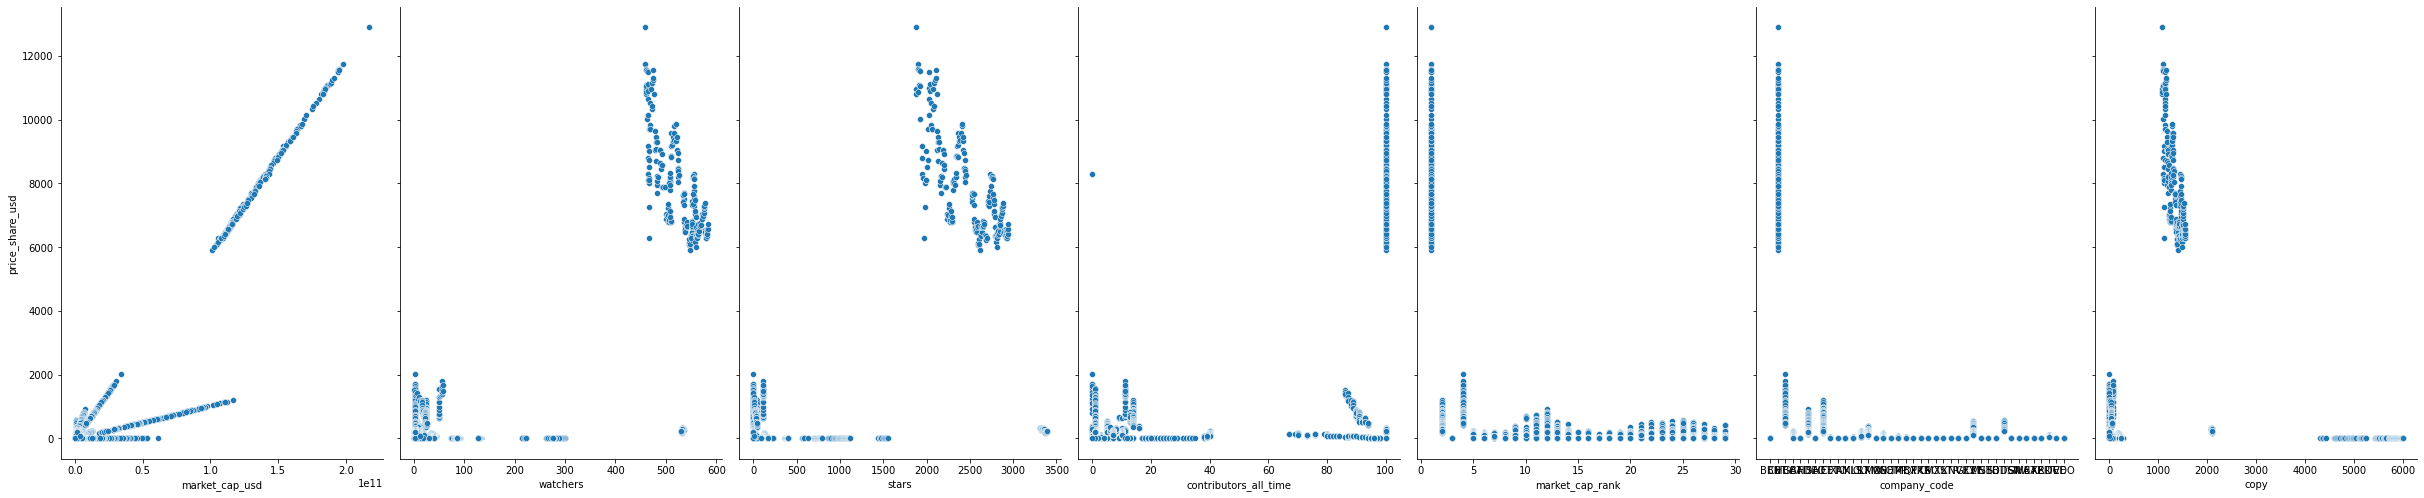

In [ ]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(df, x_vars=["market_cap_usd","watchers","stars","contributors_all_time","market_cap_rank","company_code","copy"], y_vars='price_share_usd', height=7, aspect=0.7)

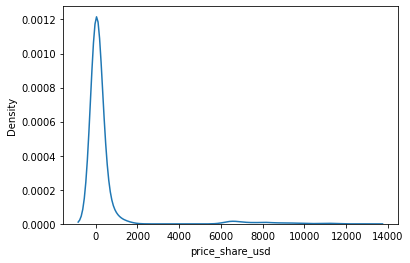

In [ ]:
sns.kdeplot(df.price_share_usd)

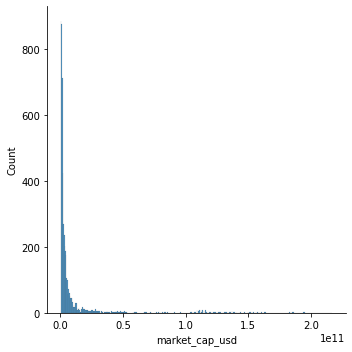

In [ ]:
sns.displot(df.market_cap_usd)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(independent, target,test_size = .2, random_state = 1234)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

NameError: ignored

In [ ]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
#hyperParameterTuning(X_train, y_train)

In [ ]:
#Tuned Model
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 7,
        min_child_weight = 1,
        n_estimators = 500,
        subsample = 0.5)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)



rsme_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("rsme: ", np.sqrt(rsme_xgb))
print("mae: ", mae_xgb)

CPU times: user 2.53 s, sys: 16 ms, total: 2.55 s
Wall time: 2.54 s
rsme:  26.709546400476857
mae:  7.2263088877940636


In [ ]:
#Cross-Validation
scoring = {'MSE' : make_scorer(mean_squared_error),
          'MAE' : make_scorer(mean_absolute_error)}
kfold = KFold(n_splits=5, random_state=1234, shuffle = True)
results_clf = cross_validate(estimator=xgb_model,X=X_train,
                                          y=y_train,
                                          cv=kfold,
                                          scoring=scoring)
results_clf

{'fit_time': array([1.63845968, 1.47848105, 1.46962476, 1.46846271, 1.48388267]),
 'score_time': array([0.0327065 , 0.03335404, 0.03299189, 0.03487945, 0.03395414]),
 'test_MAE': array([8.38862648, 7.07666094, 6.9435159 , 8.34802644, 9.08060192]),
 'test_MSE': array([1386.65848492,  538.80235284,  683.28360793, 3030.98329463,
        1060.92856664])}

In [ ]:
b_lin = np.sqrt(results_clf.get('test_MSE'))
c_lin = (results_clf.get('test_MAE'))
print('mean_RMSE : ', "%.15f" % (b_lin.mean()))
print('mean_MAE : ', "%.15f" % (c_lin.mean()))

mean_RMSE :  34.843187868730332
mean_MAE :  7.967486334879721


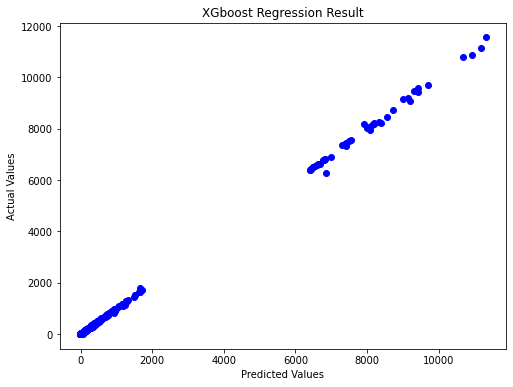

In [ ]:
# parity plot  

y_pred_train = xgb_model.predict(X_test)
fig, ax1 = plt.subplots(figsize=(8,6))
plt.scatter(y_pred_train,y_test,color='blue')
plt.title('XGboost Regression Result')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()